In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim
import random

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
# 2d input
# x,y
inputs = torch.randn(2000, 2)
# ax + by
out_dim1 = 2 * inputs[:,0] + 4 * inputs[:,1]
# y^2
out_dim2 = inputs[:,1] * 2
#out_dim2 = inputs[:,1] ** 2 + 0.5 * inputs[:,0]
outputs = torch.stack([out_dim1, out_dim2],dim=1)

In [4]:
inputs.shape, outputs.shape

(torch.Size([2000, 2]), torch.Size([2000, 2]))

In [5]:
inputs[0], outputs[0]

(tensor([-1.1258, -1.1524]), tensor([-6.8611, -2.3047]))

In [6]:
2* inputs[0][0] + 4*inputs[0][1], inputs[0][1]*2

(tensor(-6.8611), tensor(-2.3047))

In [7]:
class MyToyNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.inp_to_interm_W = nn.Parameter(torch.Tensor(2, 4))
        self.interm_to_out_W = nn.Parameter(torch.Tensor(4, 2))
        self.inp_to_interm_b = nn.Parameter(torch.Tensor(4))
        self.interm_to_out_b = nn.Parameter(torch.Tensor(2))
        
        # masks
        self.inp_to_interm_mask = torch.from_numpy(np.array([
            [1., 1., 0., 0.],
            [1., 1.,1., 1. ]
        ], dtype=np.float32))
        self.interm_to_out_mask = torch.from_numpy(np.array([
            [1., 0],
            [1., 0],
            [0., 1.],
            [0., 1.]
        ], dtype=np.float32))
        
        init.kaiming_normal_(self.inp_to_interm_W, mode='fan_in')
        init.kaiming_normal_(self.interm_to_out_W, mode='fan_in')
        self.inp_to_interm_b.data.fill_(0)
        self.interm_to_out_b.data.fill_(0)
        
    def forward(self, x):
        
        # With masking
        #"""
        masked_inp_to_interm = self.inp_to_interm_W.mul(self.inp_to_interm_mask)
        masked_interm_to_out = self.interm_to_out_W.mul(self.interm_to_out_mask)
        x = x.matmul(masked_inp_to_interm) + self.inp_to_interm_b
        x = F.tanh(x)
        x = x.matmul(masked_interm_to_out) + self.interm_to_out_b
        #x = F.relu(x)
        #"""
        # Without masking
        """
        x = x.matmul(self.inp_to_interm_W) + self.inp_to_interm_b
        x = F.tanh(x)
        x = x.matmul(self.interm_to_out_W) + self.interm_to_out_b
        #x = F.tanh(x)
        """
        return x
    
       

In [8]:
toynet = MyToyNet()
optimizer = torch.optim.SGD(toynet.parameters(), lr=1e-3, momentum=0.9)

D:\Saarbrucken\EDA_Research\seq-proj\python-env\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


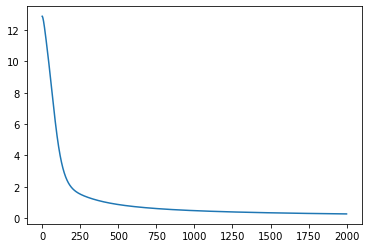

In [9]:
losses = []
for i in range(2000):
    
    outs = toynet(inputs)
    loss = F.mse_loss(outs, outputs, reduction='mean')
    #loss = (outs - outputs).pow(2).sum() / inputs.shape[0]
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(losses)
    

In [10]:
for p in toynet.parameters():
    print(p)

Parameter containing:
tensor([[ 0.1197,  0.3086, -0.2320,  0.1210],
        [ 0.5030,  0.4085, -0.5245,  0.5245]], requires_grad=True)
Parameter containing:
tensor([[ 4.6064, -0.2201],
        [ 5.8114,  0.3057],
        [-0.8482, -2.1466],
        [-0.2452,  2.3245]], requires_grad=True)
Parameter containing:
tensor([-0.0595,  0.0345,  0.0173, -0.0134], requires_grad=True)
Parameter containing:
tensor([0.0585, 0.0562], requires_grad=True)


In [11]:
toynet.inp_to_interm_mask

tensor([[1., 1., 0., 0.],
        [1., 1., 1., 1.]])

In [12]:
toynet.interm_to_out_mask

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [13]:
with torch.no_grad():
    print(toynet(inputs[0].unsqueeze(0)), outputs[0])


tensor([[-6.7371, -2.4070]]) tensor([-6.8611, -2.3047])
